# Dependencies loading

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve)

import warnings
warnings.filterwarnings('ignore')

# Data loading

In [303]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train_fe.csv")
X_test = pd.read_csv(f"{base_url}/X_test_fe.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 20) (8639, 20)
(34554, 1) (8639, 1)


In [304]:
X_train

,age,job,marital,education,balance,housing,loan,contact,duration,pdays,previous,poutcome,contact_date,customer_value_score,estimated_income,balance_per_contact,age_balance_ratio,age_bin,previous_bin,last_contact_days_bin
0,55,blue-collar,married,secondary,16873,0,0,cellular,4.369448,-1,0,other,1-jun,16873,33873,16873.0,301.303571,Senior,none,no contact
1,34,technician,married,secondary,4,1,0,cellular,4.663439,263,1,failure,2-feb,8,22004,2.0,0.114286,Middle-aged,low,long ago
2,40,admin.,married,secondary,451,1,1,unknown,5.552960,-1,0,other,29-may,451,22451,451.0,11.000000,Middle-aged,none,no contact
3,29,services,single,secondary,-142,1,0,unknown,4.948760,-1,0,other,16-may,-142,16858,-142.0,-4.733333,Young,none,no contact
4,51,technician,divorced,secondary,131,1,0,cellular,5.267858,-1,0,other,18-nov,131,22131,131.0,2.519231,Senior,none,no contact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34549,60,retired,married,secondary,2060,0,0,cellular,4.912655,95,4,failure,29-jun,10300,14060,412.0,33.770492,Senior,medium,long ago
34550,32,management,single,tertiary,0,0,0,cellular,4.060443,-1,0,other,19-nov,0,28000,0.0,0.000000,Middle-aged,none,no contact
34551,38,blue-collar,married,primary,0,0,0,unknown,5.347108,-1,0,other,13-may,0,16000,0.0,0.000000,Middle-aged,none,no contact
34552,30,admin.,single,secondary,154,1,0,cellular,3.218876,-1,0,other,21-nov,154,22154,154.0,4.967742,Young,none,no contact


# Model

## Encoding

As already explained, XGBoost cannot handle categorical data directly. Therefore, we converted all categorical variables into numeric format using label encoding. Each category was replaced with a unique numeric value, ensuring the data is compatible with XGBoost for effective processing.

In [308]:
# creating a dictionary to store LabelEncoder objects
label_encoders = {}

# lets slice the last 3 characters for 'contact_date'
X_train['contact_date'] = X_train['contact_date'].str[-3:]
X_test['contact_date'] = X_test['contact_date'].str[-3:]

# lets first create LabelEncoder for 'contact_date'
label_encoders['contact_date'] = LabelEncoder()

X_train['contact_date'] = label_encoders['contact_date'].fit_transform(X_train['contact_date'])
X_test['contact_date'] = label_encoders['contact_date'].transform(X_test['contact_date'])

# then, get all the categorical columns of object type
categorical_columns = X_train.select_dtypes(include=['object']).columns.difference(['contact_date'])

# encoding each categorical column
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    
    # fit and transform for X_train
    X_train[column] = label_encoders[column].fit_transform(X_train[column])
    
    # transform X_test using the same encoder
    X_test[column] = label_encoders[column].transform(X_test[column])

# to print Encoding and Decoding
for column, encoder in label_encoders.items():
    print(f"\n{column} Encoding and Decoding:")
    
    encoded_values = range(len(encoder.classes_))
    decoded_values = encoder.classes_
    
    for enc, dec in zip(encoded_values, decoded_values):
        print(f"{enc} -> {dec}")


contact_date Encoding and Decoding:
0 -> apr
1 -> aug
2 -> dec
3 -> feb
4 -> jan
5 -> jul
6 -> jun
7 -> mar
8 -> may
9 -> nov
10 -> oct
11 -> sep

age_bin Encoding and Decoding:
0 -> Elderly
1 -> Middle-aged
2 -> Senior
3 -> Young

contact Encoding and Decoding:
0 -> cellular
1 -> telephone
2 -> unknown

education Encoding and Decoding:
0 -> primary
1 -> secondary
2 -> tertiary

job Encoding and Decoding:
0 -> admin.
1 -> blue-collar
2 -> entrepreneur
3 -> housemaid
4 -> management
5 -> retired
6 -> self-employed
7 -> services
8 -> student
9 -> technician
10 -> unemployed

last_contact_days_bin Encoding and Decoding:
0 -> long ago
1 -> moderate
2 -> no contact
3 -> recent
4 -> very long ago

marital Encoding and Decoding:
0 -> divorced
1 -> married
2 -> single

poutcome Encoding and Decoding:
0 -> failure
1 -> other
2 -> success

previous_bin Encoding and Decoding:
0 -> high
1 -> low
2 -> medium
3 -> none


In [309]:
# initialize the model
xgb_model = XGBClassifier()

# fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [310]:
# and make predictions
y_pred = xgb_model.predict(X_test)

## Model Evaluation

### Accuracy:

In [313]:
# lets start with accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.9056603773584906

The model achieved 91% accuracy, showing good initial performance. Next, we should check other metrics like precision and recall to ensure it handles imbalances well.

### Classification Report:

In [316]:
# prediction probabilities
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# classification report
report = classification_report(y_test, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.93      0.96      0.95      7635
         Yes       0.62      0.48      0.54      1004

    accuracy                           0.91      8639
   macro avg       0.78      0.72      0.74      8639
weighted avg       0.90      0.91      0.90      8639



The model performs well for non-subscribers (class 0) with high precision and recall. However, it struggles to identify subscribers (class 1) with lower recall and f1-score. Overall accuracy is 91%, but improvements are needed for class 1 predictions.

### ROC AUC score:

In [319]:
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Test AUC: {auc_score:.4f}")

Test AUC: 0.9222


The Test AUC score of 0.9222 shows that the model performs very well in distinguishing between classes. A high AUC score reflects a strong ability to rank positive and negative instances correctly.

### Consusion Matrix:

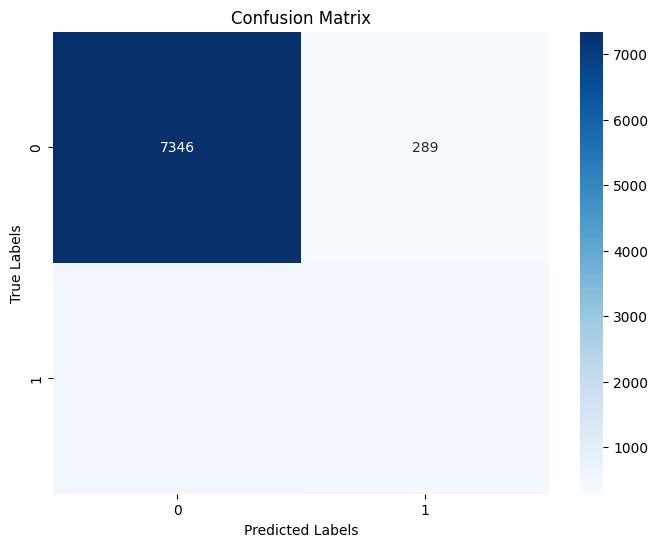

In [322]:
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Again, the confusion matrix shows the model is great at predicting non-subscribers (class 0), but it struggles with subscribers (class 1).

### ROC curve:

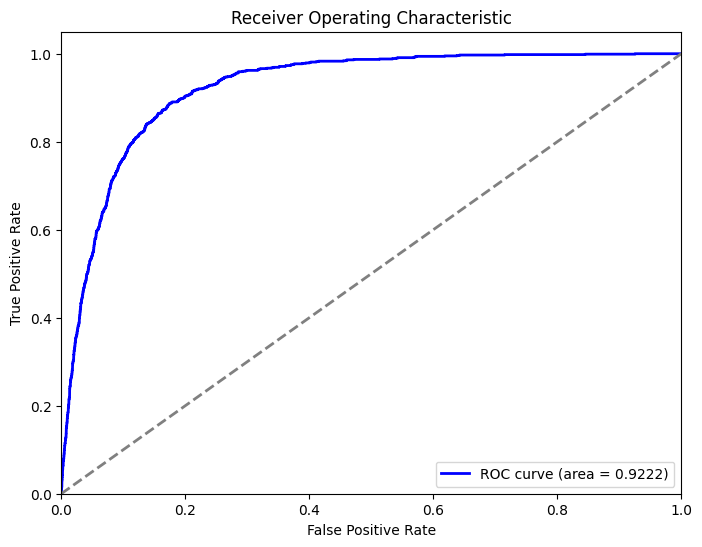

In [325]:
# prediction probabilities
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Again, the ROC curve shows the model does a great job overall, with an AUC score of 0.9222. This means it’s good at telling the two classes apart. But, there’s a catch—it struggles with the smaller group (subscribers). Since most people in the dataset didn’t subscribe, the model gets really good at predicting them, but it misses more subscribers. To fix this, we might need to balance the data or tweak how the model learns.

## Hyperparameter tunning

In [328]:
# Define the updated parameter grid to search
param_dist = {
    'n_estimators': [50, 100, 300, 500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],   
    'max_depth': [2, 3, 5, 7],                    
    'min_child_weight': [1, 5, 10, 15],           
    'subsample': [0.2, 0.3, 0.5, 0.7, 0.9],           
    'colsample_bytree': [0.2, 0.3, 0.5, 0.7, 0.9],    
    'gamma': [1.0, 2.0, 5.0],                 
    'scale_pos_weight': [1, 2, 3, 4],       
    'reg_alpha': [50, 100, 200], # L1 regularization
    'reg_lambda': [50, 100, 200] # L2 regularization
}

# lets initialize the XGBoost model
xgb_model = xgb.XGBClassifier()

# perform RandomizedSearchCV with early stopping
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=50, scoring='average_precision', cv=10, random_state=42)

# fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = random_search.best_params_
print("Best Parameters: ", best_params)

# train the final model with the best parameters
bst = xgb.XGBClassifier(**best_params)

bst.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="aucpr",             
    early_stopping_rounds=20, 
    verbose=True
)

# lets make predictions
bst_preds = bst.predict(X_test)

Best Parameters:  {'subsample': 0.7, 'scale_pos_weight': 4, 'reg_lambda': 50, 'reg_alpha': 50, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 2.0, 'colsample_bytree': 0.2}
[0]	validation_0-aucpr:0.21411	validation_1-aucpr:0.20202
[1]	validation_0-aucpr:0.23525	validation_1-aucpr:0.22327
[2]	validation_0-aucpr:0.25771	validation_1-aucpr:0.24602
[3]	validation_0-aucpr:0.26001	validation_1-aucpr:0.24845
[4]	validation_0-aucpr:0.33236	validation_1-aucpr:0.32980
[5]	validation_0-aucpr:0.33207	validation_1-aucpr:0.33117
[6]	validation_0-aucpr:0.34211	validation_1-aucpr:0.33804
[7]	validation_0-aucpr:0.35045	validation_1-aucpr:0.34499
[8]	validation_0-aucpr:0.34472	validation_1-aucpr:0.33948
[9]	validation_0-aucpr:0.34239	validation_1-aucpr:0.33360
[10]	validation_0-aucpr:0.34323	validation_1-aucpr:0.33660
[11]	validation_0-aucpr:0.36119	validation_1-aucpr:0.35232
[12]	validation_0-aucpr:0.36049	validation_1-aucpr:0.35110
[13]	validation_0-aucpr:0.

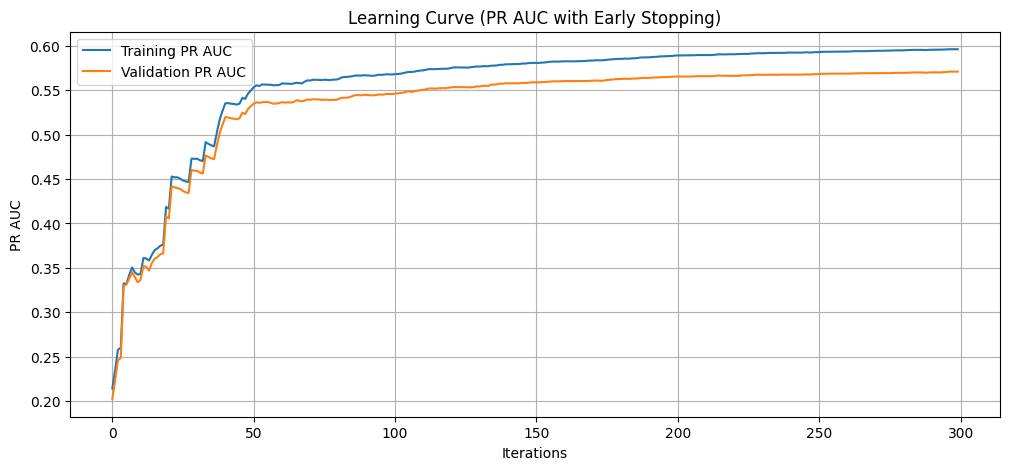

In [329]:
# plot the learning curve for PR AUC
def plot_pr_auc_curve(bst):
    results = bst.evals_result()
    train_aucpr = results['validation_0']['aucpr']
    test_aucpr = results['validation_1']['aucpr']

    plt.figure(figsize=(12, 5))
    plt.plot(train_aucpr, label="Training PR AUC")
    plt.plot(test_aucpr, label="Validation PR AUC")
    plt.xlabel("Iterations")
    plt.ylabel("PR AUC")
    plt.title("Learning Curve (PR AUC with Early Stopping)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pr_auc_curve(bst)

## Model Evaluation

### Classification report:

In [333]:
bst_preds = bst.predict(X_test)

report = classification_report(y_test, bst_preds, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.96      0.90      0.93      7635
         Yes       0.49      0.73      0.58      1004

    accuracy                           0.88      8639
   macro avg       0.72      0.81      0.76      8639
weighted avg       0.91      0.88      0.89      8639



The F1-score improvements, while not remarkable, are still meaningful. Accuracy saw a slight decline, but the impact is minimal. Most importantly, recall for true positives—our main focus—rose significantly, showing the model's better ability to identify potential subscribers. Precision, indicating the proportion of correctly predicted subscribers, decreased. However, our priority remains recall to ensure we capture as many potential subscribers as possible. A few false positives are acceptable in this trade-off!

### ROC curve:

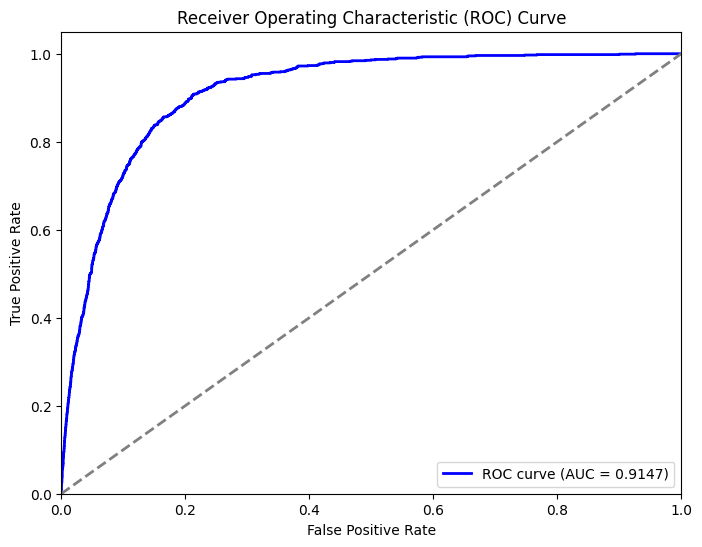

In [338]:
# prediction probabilities
y_test_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# ROC AUC score
auc_score = roc_auc_score(y_test, y_test_proba)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The AUC score slightly decreased, but it’s nothing to be concerned about. The trade-off is worth it as the recall for true positives—our primary objective—improved significantly.

### Confusion Matrix

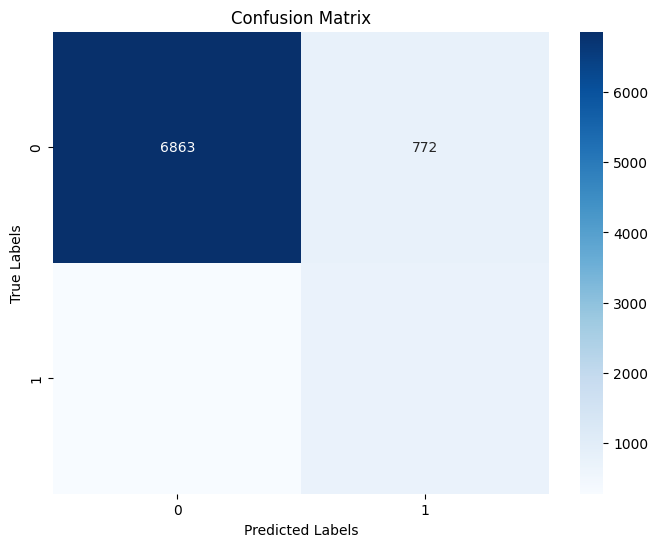

In [346]:
# make predictions
y_pred = random_search.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

After hyperparameter tuning, the matrix shows an increase in correctly identified subscribers, though some misclassifications remain.

## Feature selection:

Feature selection is all about finding the most important pieces of data to focus on. It helps simplify the model, makes it run faster, and improves it by cutting out the noise. It’s like keeping only what truly matters!

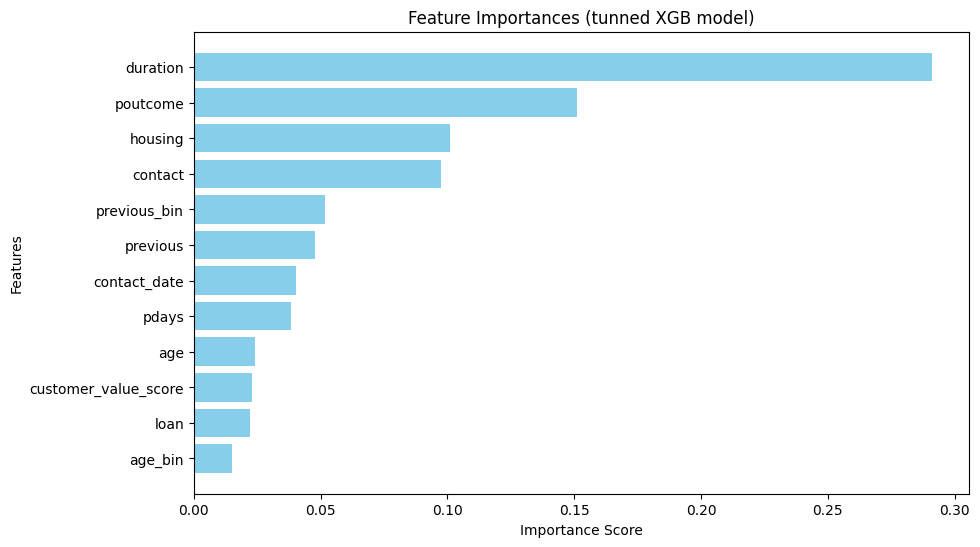

In [352]:
# get feature importances from the hp tunned model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, bst.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns=headers)

features = feature_importances.head(12)

# plot
plt.figure(figsize=(10, 6))
plt.barh(features['name'], features['score'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances (tunned XGB model)')

plt.gca().invert_yaxis()
plt.show()

Let's filter using a 5% threshold:

In [354]:
important_features = feature_importances[feature_importances['score'] > 0.05]['name'].tolist()
important_features

['duration', 'poutcome', 'housing', 'contact', 'previous_bin']

In [355]:
# let's filter on important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# initialize the tunned model
xgb_model_filtered = xgb.XGBClassifier(**random_search.best_params_)

# and retrain the model on the filtered dataset
xgb_model_filtered.fit(X_train_filtered, y_train)

# lets make predictions
y_pred_filtered = xgb_model_filtered.predict(X_test_filtered)

## Model Evaluation

### Classification report:

In [358]:
filtered_report = classification_report(y_test, y_pred_filtered, target_names=["No", "Yes"])
print(filtered_report)

              precision    recall  f1-score   support

          No       0.95      0.90      0.93      7635
         Yes       0.46      0.63      0.53      1004

    accuracy                           0.87      8639
   macro avg       0.70      0.77      0.73      8639
weighted avg       0.89      0.87      0.88      8639



**Got worst!** Did not improve at all with feature selection unfortunately.

### ROC curve:

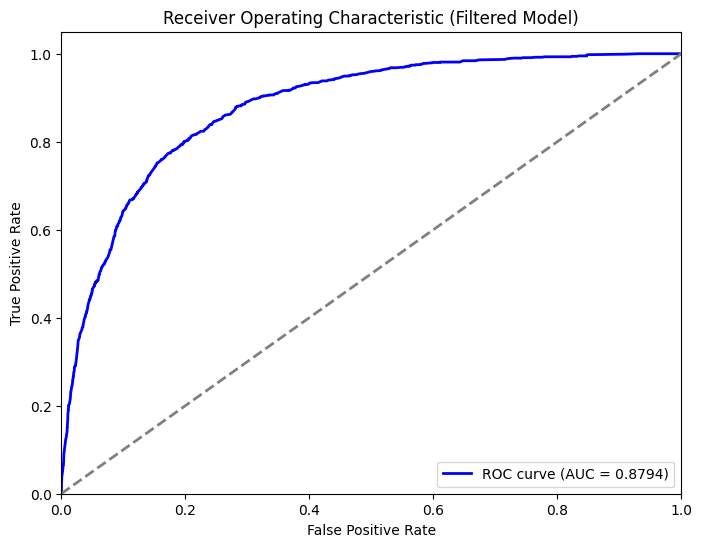

In [361]:
# get predicted probabilities for the filtered model
y_test_proba_filtered = xgb_model_filtered.predict_proba(X_test_filtered)[:, 1]

# ROC AUC score
auc_score_filtered = roc_auc_score(y_test, y_test_proba_filtered)

# ROC curve
fpr_filtered, tpr_filtered, _ = roc_curve(y_test, y_test_proba_filtered)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_filtered, tpr_filtered, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score_filtered:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Filtered Model)')
plt.legend(loc="lower right")
plt.show()

Also got worst!

### Confusion matrix:

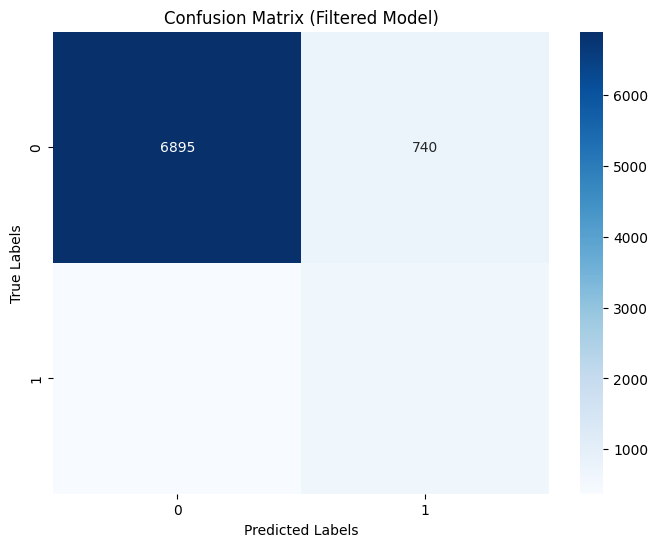

In [364]:
# make predictions
y_pred_filtered = xgb_model_filtered.predict(X_test_filtered)

# confusion matrix (filtered)
cm_filtered = confusion_matrix(y_test, y_pred_filtered)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Filtered Model)')
plt.show()

# Summary

After fine-tuning, the XGBoost model strikes a better balance between "Yes" (subscribers) and "No" (non-subscribers). Accuracy dropped slightly to 88% from 91%, a small trade-off for improved handling of the minority class. Precision for "Yes" is 49%, meaning some false positives, but recall improved to 73%, capturing more true subscribers—key for identifying leads. For "No," the model maintains strong precision (96%) and recall (90%). The ROC AUC score of 0.91 confirms solid overall performance.

Feature selection didn’t help, so we’re using the tuned model without it as our final choice.